#**Linear Classifier in Tensorflow**

We are now going to go through the book's example of implementing a linear classifier from scratch using Tensorflow. We already demonstrated our procedure using Keras + Tensorflow, so this is just another example to reinforce understanding.

#*Simulate Data*

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # for cross tabulation to make confusion matrix.

# We will ultimately have 2000 observations, 1000 1's and 1000 0's. 
# We are drawing a two inputs (x's) which are jointly normal, taking on average values of 0 and 3 when the outcome is 0, and values of 3 and 0 when the outcome is 1. 
# The cov are covariance matrices, defining how the two x's associate with one another. 
num_samples_per_class = 1000 
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

# Now we stack the two vector pairs together into a single dataset. 
samples = np.vstack((negative_samples,positive_samples))

labels = np.vstack((np.zeros((1000,1)),np.ones((1000,1))))

Plotting the resultant data...

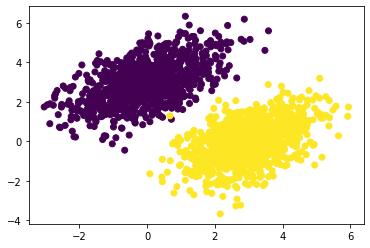

In [ ]:
# We make a scatter plot of the first and second columns of the samples matrix (x1 and x2)
# The colors are assigned based on the target label for each observation.
plt.scatter(samples[:,0],samples[:,1],c=labels[:,0])
plt.show()

#*Define Data, Parameters, and Model*

In [ ]:
# Our first layer is the two inputs, and then we have it mapping directly into an output layer, which yields a continuous prediction. 
# We will apply a threshold to the prediction to get our classification.
input_dim = 2
output_dim = 1

# Here we define matrix W and vector b, our weights and biases.
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

# This is just the w*x+b without an activation.
def model(inputs):
    return tf.matmul(inputs, W) + b
    

# We will use MSE loss: mean[(target-prediction)^2]
def square_loss(predictions,targets):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

# This is the scalar multiple we will apply against gradients for the updates.
learning_rate = 0.1 

# A single training step will take the input data, and the target labels.
# It performs a forward pass, calculates current loss, does the backward pass to get gradients...
# Finally, it updates W and b based on resulting gradients.
def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate) # assign_sub() subtracts the argument value from the current value in place. 
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

Now we can implement our linear classifier (note, in econometrics, we would call this a linear probability model). We first take our simulated data and declare it as tensors that Tensorflow can work with. Defining these as float32 because they were originally doubles. Need them to match datatype with the weight tensors. 

In [ ]:
data = tf.constant(samples,dtype="float32")
groundTruth = tf.constant(labels,dtype="float32")

for step in range(40):
    loss = training_step(data,groundTruth)
    print("Loss at step ",step,": ",loss.numpy(),sep="")

Loss at step 0: 5.095086
Loss at step 1: 0.5814293
Loss at step 2: 0.19867706
Loss at step 3: 0.150975
Loss at step 4: 0.13629724
Loss at step 5: 0.12571311
Loss at step 6: 0.116372496
Loss at step 7: 0.10792409
Loss at step 8: 0.10026247
Loss at step 9: 0.093312494
Loss at step 10: 0.08700783
Loss at step 11: 0.08128855
Loss at step 12: 0.07610031
Loss at step 13: 0.07139378
Loss at step 14: 0.06712427
Loss at step 15: 0.06325119
Loss at step 16: 0.059737712
Loss at step 17: 0.05655047
Loss at step 18: 0.053659163
Loss at step 19: 0.05103631
Loss at step 20: 0.04865699
Loss at step 21: 0.046498593
Loss at step 22: 0.044540595
Loss at step 23: 0.042764403
Loss at step 24: 0.04115313
Loss at step 25: 0.039691467
Loss at step 26: 0.03836551
Loss at step 27: 0.037162676
Loss at step 28: 0.036071528
Loss at step 29: 0.03508169
Loss at step 30: 0.034183756
Loss at step 31: 0.033369195
Loss at step 32: 0.03263027
Loss at step 33: 0.031959947
Loss at step 34: 0.031351868
Loss at step 35: 0.03

Now, we can pull out the predictions from the final fit model, and apply a threshold of 0.5 for the predictions (1 vs 0). 

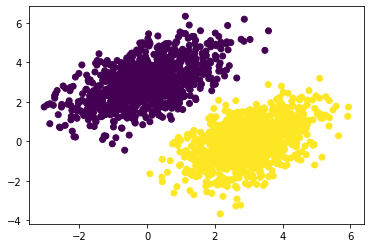

Actual,False,True
Predicted,,
False,1000,1
True,0,999


In [ ]:
# It does a pretty good job. 
predictions = model(data)
plt.scatter(data[:, 0], data[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

confusionMatrix = pd.DataFrame({"Predicted":predictions[:,0]>0.5,"Actual":groundTruth[:,0].numpy().astype(np.bool)})
pd.crosstab(confusionMatrix['Predicted'],confusionMatrix['Actual'])

#**Again, using Keras, with Validation**

We are going to train the same classifier again. This time, however, we are going to use the Keras API to simplify things, and we will incorporate a holdout dataset for model evaluation. 

In [ ]:
from tensorflow import keras 
from tensorflow.keras import layers
  
model = keras.Sequential([
    layers.Dense(1, activation="linear")
])

model.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["mse"])

# Here we are taking the row indices of the data and scrambling their order.  
indices_permutation = np.random.permutation(len(samples))

# We are then using the result to shuffle the observations in our data.
shuffled_inputs = samples[indices_permutation]
shuffled_targets = labels[indices_permutation]
 
# Here we are saying that 30% of the data will be selected to serve as validation.
num_validation_samples = int(0.3 * len(samples))

# Now we are pulling out the validation samples.
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]

# And here we are pulling out the training samples.
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

# Finally, when we call the fit function, we separately specify training data and validation data.
# We indicate the latter using the validation_data argument. 
history = model.fit(
    training_inputs,
    training_targets,
    epochs=60,
    batch_size=50,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/60
28/28 [==============================] - 1s 5ms/step - loss: 6.5316 - mse: 6.5316 - val_loss: 5.7457 - val_mse: 5.7457
Epoch 2/60
28/28 [==============================] - 0s 2ms/step - loss: 5.9335 - mse: 5.9335 - val_loss: 5.2402 - val_mse: 5.2402
Epoch 3/60
28/28 [==============================] - 0s 2ms/step - loss: 5.4041 - mse: 5.4041 - val_loss: 4.7658 - val_mse: 4.7658
Epoch 4/60
28/28 [==============================] - 0s 2ms/step - loss: 4.9005 - mse: 4.9005 - val_loss: 4.3109 - val_mse: 4.3109
Epoch 5/60
28/28 [==============================] - 0s 2ms/step - loss: 4.4250 - mse: 4.4250 - val_loss: 3.8879 - val_mse: 3.8879
Epoch 6/60
28/28 [==============================] - 0s 2ms/step - loss: 3.9822 - mse: 3.9822 - val_loss: 3.4897 - val_mse: 3.4897
Epoch 7/60
28/28 [==============================] - 0s 2ms/step - loss: 3.5656 - mse: 3.5656 - val_loss: 3.1182 - val_mse: 3.1182
Epoch 8/60
28/28 [==============================] - 0s 2ms/step - loss: 3.1726 - mse: 3.17

After the model fitting is complete, we call the evaluate function, and pass it the validation data. Note that batch size here is not the same batch size in the fit() call. Batch size here refers to batches of observations in validation data to run through (predictions and loss calculations)

5/5 [==============================] - 0s 2ms/step - loss: 0.0247 - mse: 0.0247


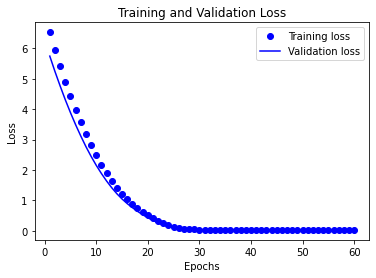

In [ ]:
loss_and_metrics = model.evaluate(val_inputs, val_targets, batch_size=128)

history_dict = history.history
history_dict.keys()

# Notice that there's basically no overfitting going on.
# Because there's no noise in the data for the network to fit to! 
trn_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(trn_loss_values) + 1)
plt.plot(epochs, trn_loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()